In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import mean_squared_error as mse

### April Data

In [5]:
df = pd.read_csv('inputs/SVMD_1.csv')

In [6]:
df.shape

(1440, 4)

In [5]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader

In [9]:
orig_df = pd.read_csv('inputs/DS1_1440.csv')

In [11]:
imfs = np.array([df[col].values for col in df.columns])

In [13]:
error = orig_df.wind_speed.values - imfs.sum(axis=0)

In [21]:
error.shape

(1440,)

In [22]:
tot_decomp = np.concatenate([imfs, error.reshape(1, -1)], axis=0)

In [23]:
tot_decomp.shape

(5, 1440)

In [6]:
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        item = self.x[idx]
        label = self.y[idx]
        
        return item, label

In [2]:
class CNNFORECAST(nn.Module):
    def __init__(self):
        super(CNNFORECAST,self).__init__()
        self.conv1d = nn.Conv1d(5, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1) # batch_size * 64
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [8]:
from processing import create_features, split_data

In [9]:
window_size = 5

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
global tot_valid_loss

In [11]:
def Train(model, train_loader, optimizer, criterion):
        
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        

    
    # print(f'train_loss {train_loss}')
    
def Valid(model, valid_loader, optimizer, criterion):
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss


In [12]:
epochs = 200

In [16]:
all_predctions = []

In [41]:
for i in range(len(tot_decomp)):

    model = CNNFORECAST().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.MSELoss()

    train_len = int(.6*tot_decomp.shape[1])
    train_data, val_data, test_data = split_data(tot_decomp[i, :], train_len)
    train_data = np.float32(train_data)
    val_data = np.float32(val_data)
    test_data = np.float32(test_data)

    xtrain, ytrain = create_features(train_data, window_size)
    xval, yval = create_features(val_data, window_size)
    xtest, ytest = create_features(test_data, window_size)

    train = WindDataset(xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1), ytrain)
    valid = WindDataset(xval.reshape(xval.shape[0], xval.shape[1], 1), yval)
    test = WindDataset(xtest.reshape(xtest.shape[0], xtest.shape[1], 1), ytest)
    train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)


    for epoch in range(epochs):
        # print('epochs {}/{}'.format(epoch+1,epochs))
        Train(model, train_loader, optimizer, criterion)
        Valid(model, valid_loader, optimizer, criterion)
        gc.collect()

    predictions = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            for input in inputs:
                preds = model.forward(input)
                
                predictions.append(preds.item())
    all_predctions.append(predictions)
            

In [50]:
ytes.shape

(1435,)

In [51]:
_, _, test = split_data(orig_df.wind_speed.values, train_len)
_, ytes = create_features(test, window_size)

all_preds = np.array([pred for pred in all_predctions]).sum(axis=0)
mse(all_preds, ytes)


0.5172060386573049

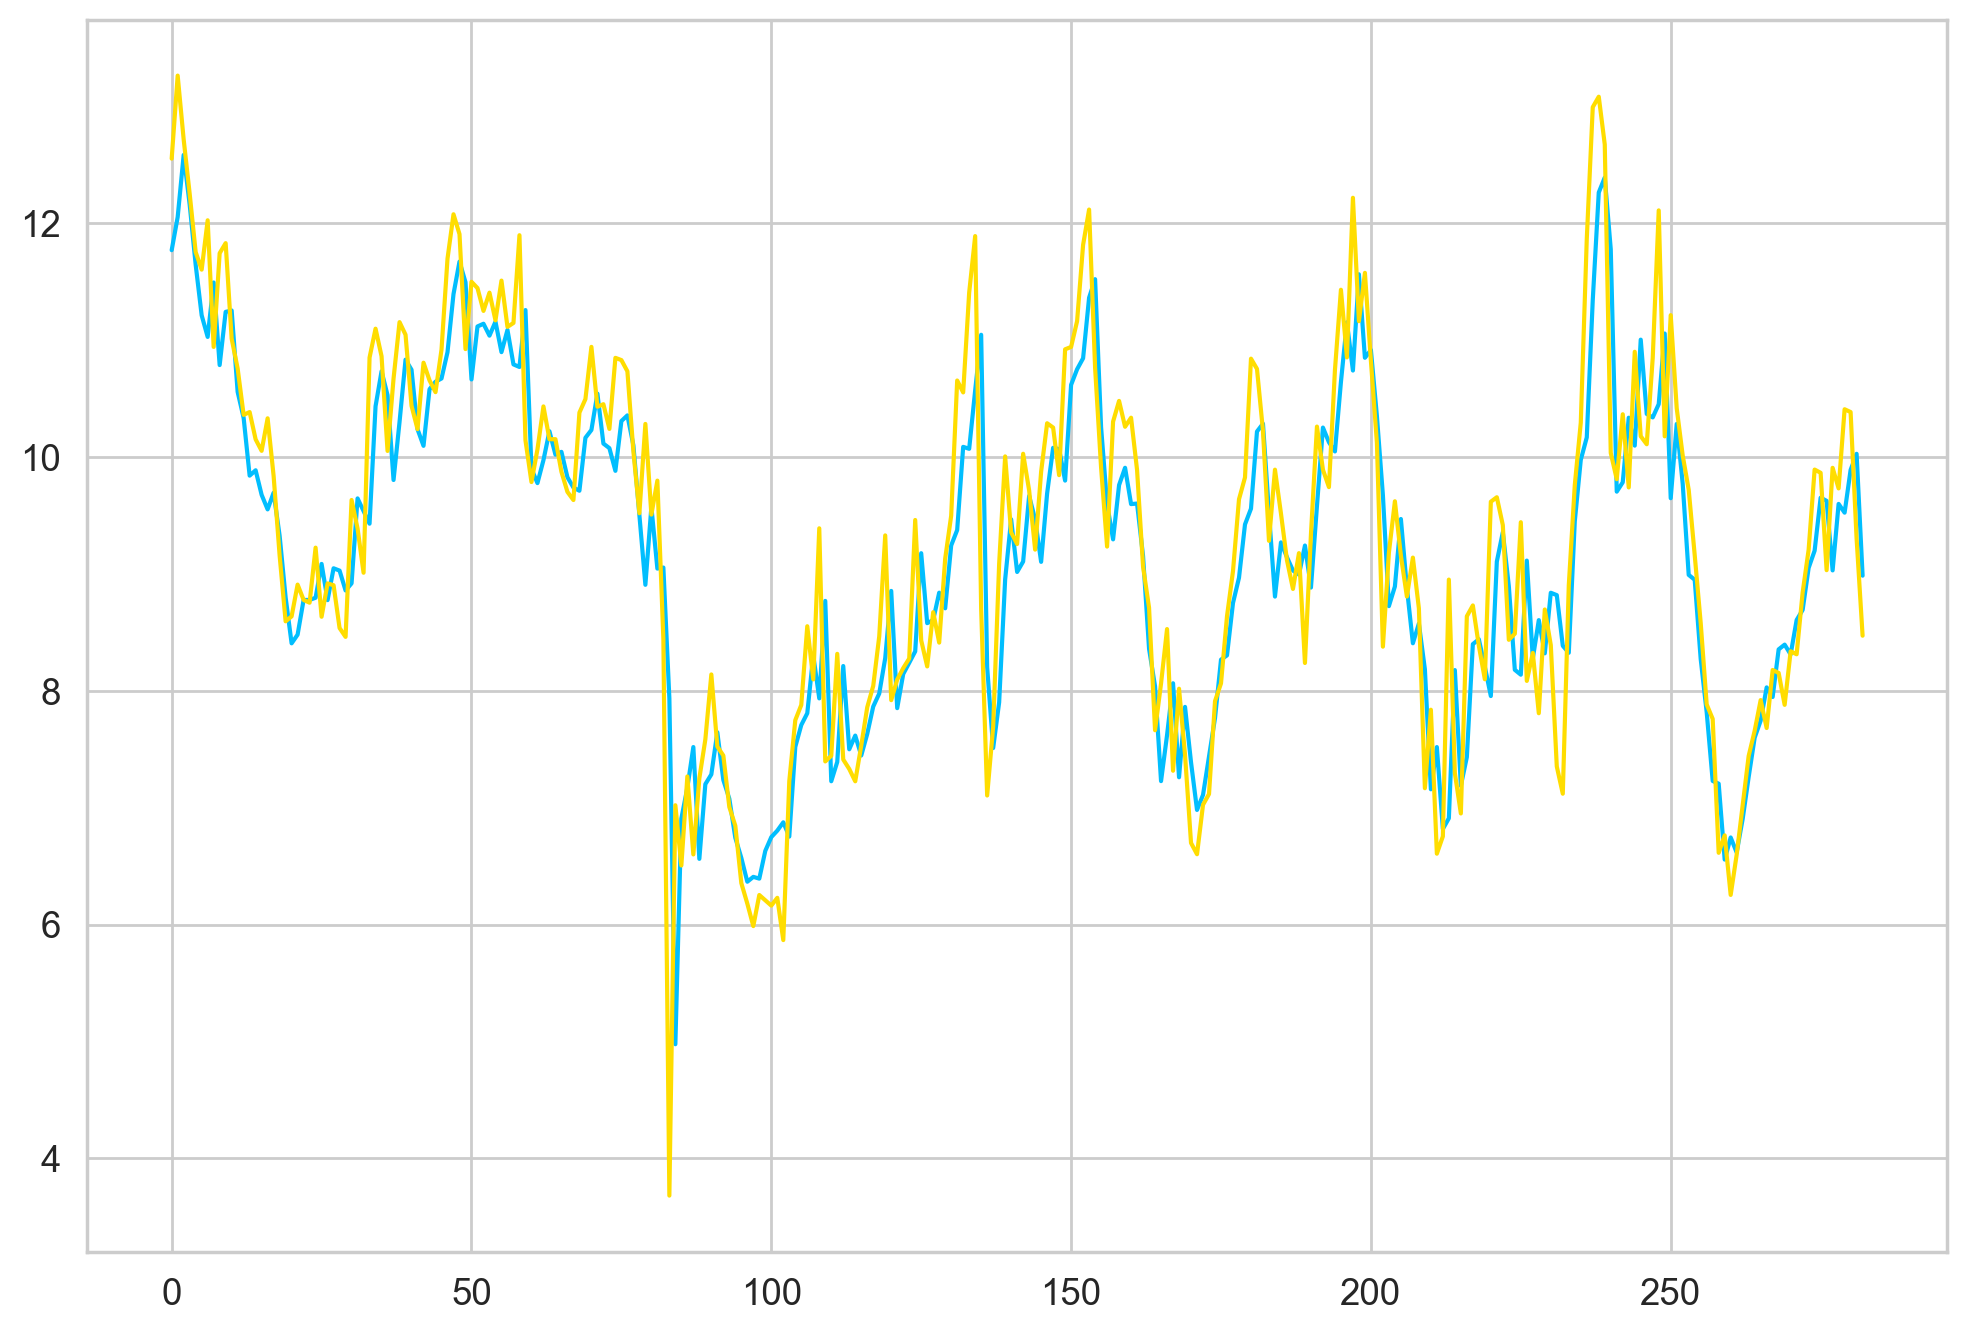

In [52]:
plt.plot(all_preds)
plt.plot(ytes)

In [13]:
import pickle

In [54]:
file = open('svmd_cnn_1', 'ab')
pickle.dump(all_preds, file)
file.close()

#### May Data

In [14]:
orig_df = pd.read_csv('inputs/DS2_1448.csv')

In [15]:
df = pd.read_csv('inputs/SVMD_2.csv')

In [16]:
imfs = np.array([df[col].values for col in df.columns])

In [17]:
error = orig_df.wind_speed.values - imfs.sum(axis=0)

In [18]:
error.shape, orig_df.shape, imfs.shape

((1488,), (1488, 2), (6, 1488))

In [19]:
tot_decomp = np.concatenate([imfs, error.reshape(1, -1)], axis=0)

In [20]:
tot_decomp.shape

(7, 1488)

In [21]:
all_predctions = []

In [22]:
for i in range(len(tot_decomp)):

    model = CNNFORECAST().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.MSELoss()

    train_len = int(.6*tot_decomp.shape[1])
    train_data, val_data, test_data = split_data(tot_decomp[i, :], train_len)
    train_data = np.float32(train_data)
    val_data = np.float32(val_data)
    test_data = np.float32(test_data)

    xtrain, ytrain = create_features(train_data, window_size)
    xval, yval = create_features(val_data, window_size)
    xtest, ytest = create_features(test_data, window_size)

    train = WindDataset(xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1), ytrain)
    valid = WindDataset(xval.reshape(xval.shape[0], xval.shape[1], 1), yval)
    test = WindDataset(xtest.reshape(xtest.shape[0], xtest.shape[1], 1), ytest)
    train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)


    for epoch in range(epochs):
        # print('epochs {}/{}'.format(epoch+1,epochs))
        Train(model, train_loader, optimizer, criterion)
        Valid(model, valid_loader, optimizer, criterion)
        gc.collect()

    predictions = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            for input in inputs:
                preds = model.forward(input)
                
                predictions.append(preds.item())
    all_predctions.append(predictions)
            

In [23]:
_, _, test_2 = split_data(orig_df.wind_speed.values, train_len)
_, ytest_2 = create_features(test_2, window_size)

all_preds = np.array([pred for pred in all_predctions]).sum(axis=0)
mse(all_preds, ytest_2)


0.7591506383170132

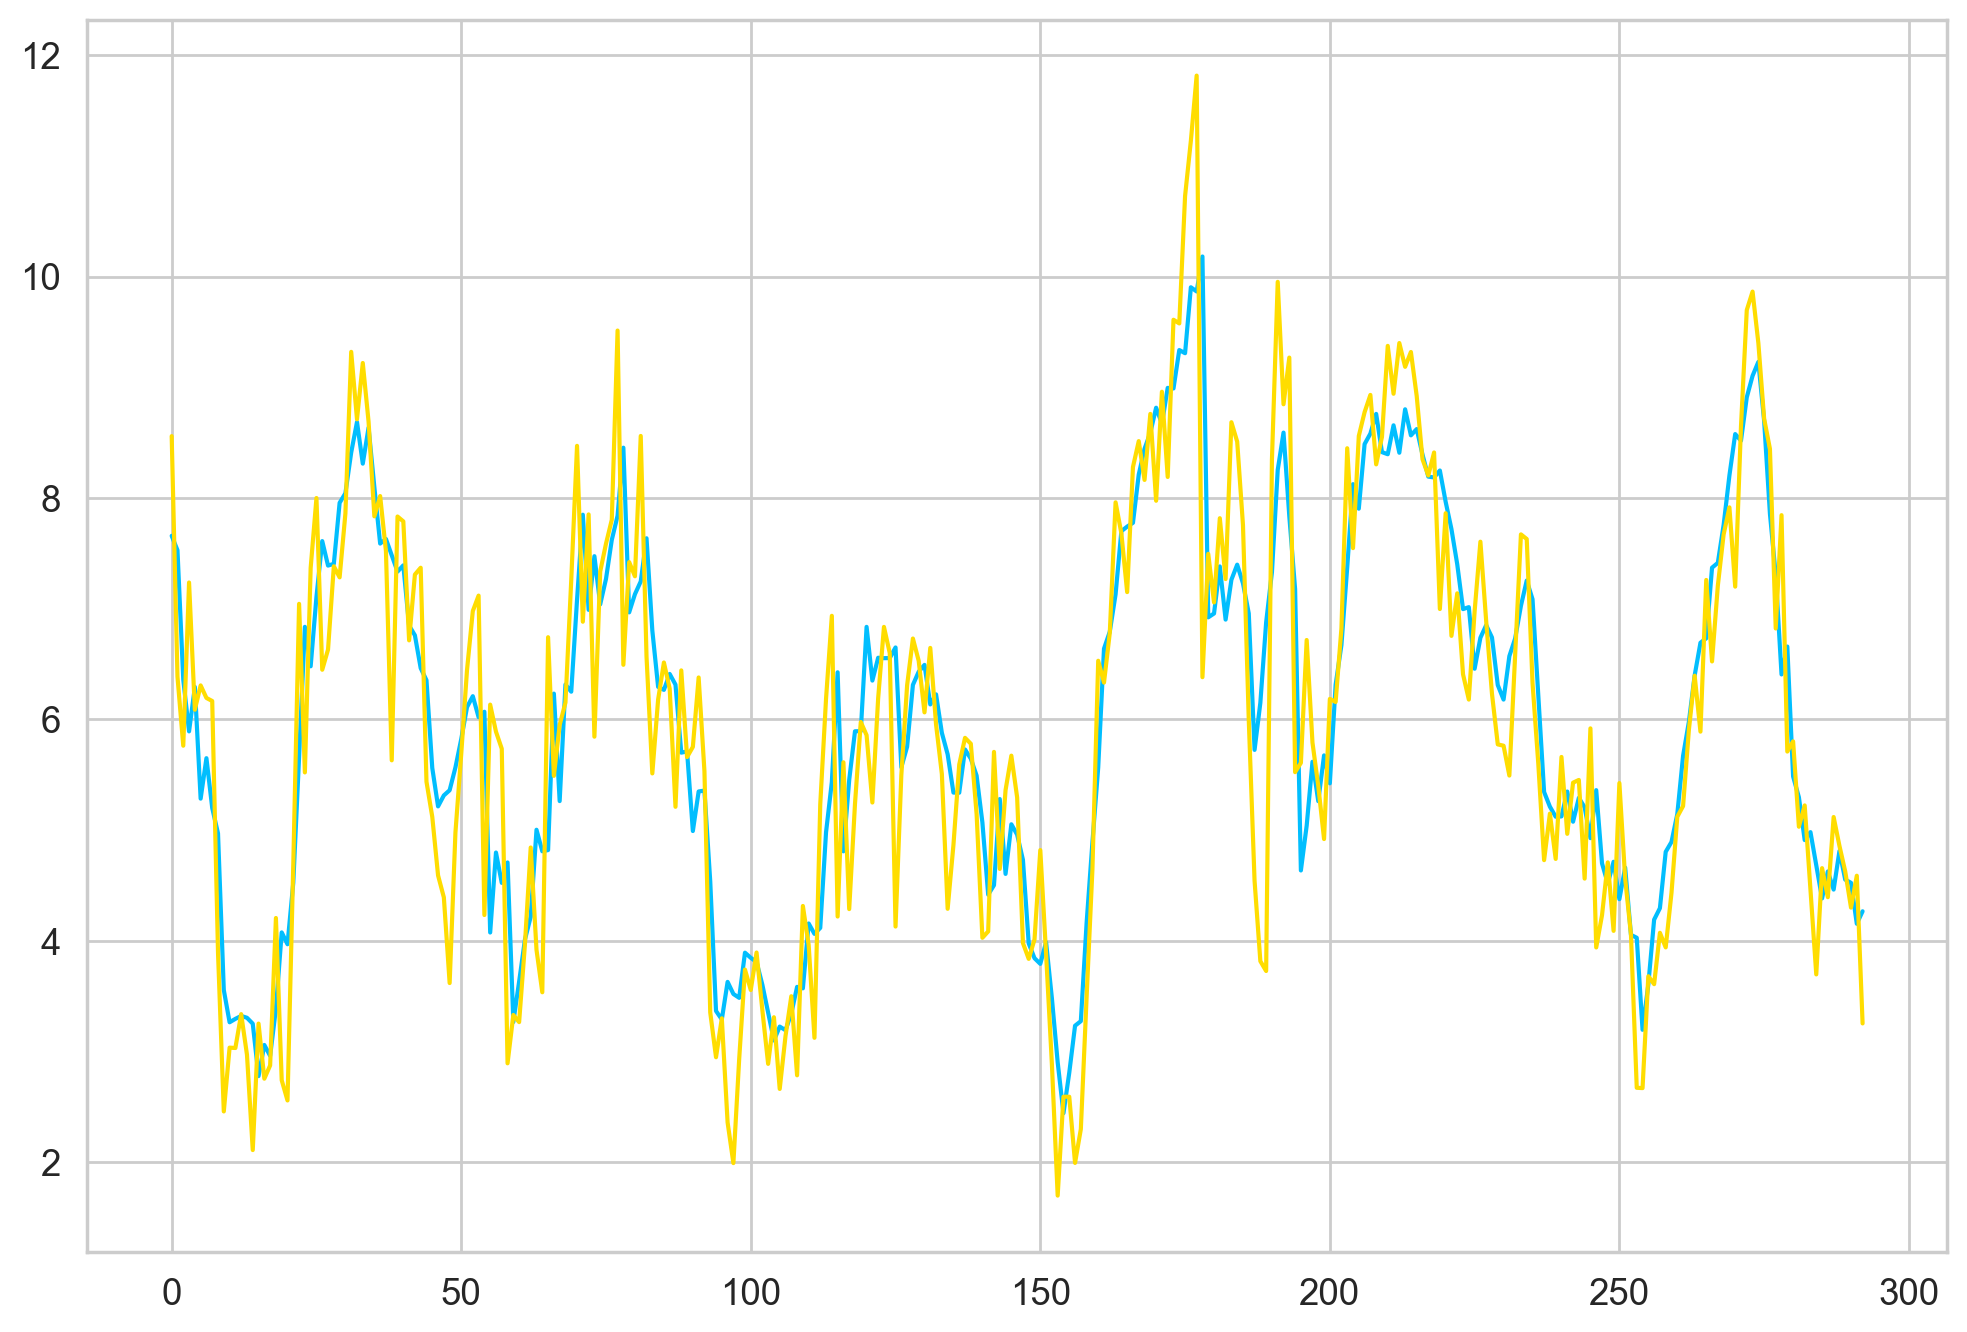

In [25]:
plt.plot(all_preds, label='Predicted')
plt.plot(ytest_2, label="Actual")